In [1]:
import bs4
import requests
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from PIL import Image
import requests
from io import BytesIO

In [2]:
new_cmap1 = LinearSegmentedColormap.from_list("", ["#BE0B00", "#FFFD1A", "#00B24E"])
new_cmap2 = LinearSegmentedColormap.from_list("", ["#6F309E", "#FA0100", "#FBB5A4",
                                                   "#FFFE07", "#E2EEDE", "#8FCF55"])

In [3]:
def get_data(url):
    try:
        data = requests.get(url)
        data.raise_for_status() #raise error if occured
        return data
    except:
        return False  

In [58]:
def get_seasons_href(soup):
    seasons_info = soup.find(id="title-episode-widget")
    if seasons_info:
        seasons = seasons_info.select(".seasons-and-year-nav > div:nth-child(4)")[0].find_all("a")
        return [["https://www.imdb.com" + season["href"] for season in seasons], 
                [season.text for season in seasons]]
    else:
        print("Error. Probably not a series")
        return False

In [ ]:
def get_years_href(soup):
    seasons_info = soup.find(id="title-episode-widget")
    if seasons_info:
        seasons = seasons_info.select(".seasons-and-year-nav > div:nth-child(4)")[0].find_all("a")
        return [["https://www.imdb.com" + season["href"] for season in seasons], 
                [season.text for season in seasons]]
    else:
        print("Error. Probably not a series")
        return False

In [5]:
def get_rating_matrix(seasons_href):
    rating_matrix = []
    for season_href in seasons_href:
        try:
            season_html = requests.get(season_href)
            season_html.raise_for_status() #raise error if occured
            rating_info = bs4.BeautifulSoup(season_html.text, "html.parser")
            ratings = rating_info.find_all("div", class_="ipl-rating-star small")
            rating_matrix.append([rating.find("span", class_="ipl-rating-star__rating").text 
                                 for rating in ratings]) 
        except:
            return False
    max_length = max(map(len, rating_matrix))
    return np.array([rating_i + [None]*(max_length - len(rating_i)) 
                     for rating_i in rating_matrix]).astype(float)

In [220]:
def get_heatmap(rating_matrix, x_labels, info, color_map):
    title = "\n".join([info["original_title"], info["date_country"], 
                       "\n".join(info["genres"].split(", "))])
    if rating_matrix.shape[0] == 1 and rating_matrix.shape[1] > 40:
        y_len = int(np.ceil(rating_matrix.shape[1]/10))
        x_len = 10
        rating_matrix = np.resize(rating_matrix, [y_len, x_len])
        rating_matrix[rating_matrix == 0] = 'nan'
        
        figsize = (10, min(10, y_len))
        fig = plt.figure(facecolor='#888A85', figsize=figsize)
        ax = sns.heatmap(rating_matrix, annot=True, 
                cmap = color_map, xticklabels=range(1, 11), 
                yticklabels=[str(i) + '_' for i in range(y_len)])
        ax.set_xlabel("One season, all episodes", fontsize=14) 
                         
    else:
        rating_matrix = rating_matrix.T
        n_episodes, n_seasons = rating_matrix.shape
        
        figsize = (max(3, n_seasons*1.5), 
                   max(4, n_episodes/1.5))
        fig = plt.figure(facecolor='#888A85', figsize=figsize)
        ax = sns.heatmap(rating_matrix, annot=True, 
                cmap = color_map, xticklabels=x_labels, 
                yticklabels=range(1, n_episodes+1))
        ax.set_xlabel('Season', fontsize=14)
        ax.set_ylabel('Episode', fontsize=14) 
    
    ax.set_title(title, fontsize=16)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    ax.tick_params(axis='both', rotation=0)
    plt.tight_layout()
    
    return fig

In [216]:
def get_serial_info(soup):
    info_html = soup.find("div", class_="title_bar_wrapper")
    title = (info_html.h1.text).strip()
    original_title = info_html.find("div", class_="originalTitle").text
    original_title = " ".join(original_title.split()[:-2])
    *genres, date_country = [tag.text.strip() for tag in info_html.select(".subtext > a")]
    rating_attr = info_html.strong["title"].split()
    rating, n_votes = float(rating_attr[0]), int(rating_attr[3].replace(',', ''))
    movie_info = {"title": title, "original_title": original_title, 
                  "genres": ", ".join(genres), "date_country": date_country, 
                  "rating_attr": rating_attr, "rating": rating, "n_votes": n_votes}
    
    return movie_info

def get_poster(soup):
    poster_html = requests.get(soup.find("div", class_="poster").img["src"])
    return Image.open(BytesIO(poster_html.content))

In [217]:
def show_all(fig, poster):
    buf = BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    heatmap = Image.open(buf)
    total_width = heatmap.size[0] + poster.size[0]
    max_height = max(heatmap.size[1], poster.size[1])
    
    full_image = Image.new('RGB', (total_width, max_height), color="#888A85")
    x_offset = 0
    full_image.paste(poster, (x_offset,0))
    x_offset += poster.size[0]
    full_image.paste(heatmap, (x_offset,0))

    return full_image
    #buf.close()

In [226]:
def serial_heatmap(url, save=False, colors=3):
    res = get_data(url)
    soup = bs4.BeautifulSoup(res.text, "html.parser")
    movie_info = get_serial_info(soup)
    poster = get_poster(soup)
    parts_href, parts_name = get_seasons_href(soup)   
    if parts_href == False: exit()
    rating_matrix = get_rating_matrix(parts_href[::-1])
    if colors == 3: cmap = new_cmap1
    else: cmap = new_cmap2
    fig = get_heatmap(rating_matrix, parts_name[::-1], movie_info, cmap);
    full_image = show_all(fig, poster)
    if save: full_image.save('./' + movie_info["original_title"] + '.jpg', 'JPEG')
    full_image.show()

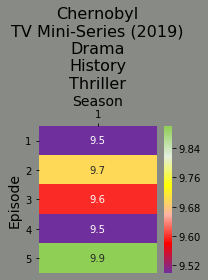

In [228]:
love_d_r = "https://www.imdb.com/title/tt9561862/?ref_=nv_sr_srsg_0"
url_test2 = "https://www.imdb.com/title/tt0149460/?ref_=nv_sr_srsg_0"
url_test3 = "https://www.imdb.com/title/tt0460681/?ref_=nv_sr_srsg_0"
chernobyl = "https://www.imdb.com/title/tt7366338/?ref_=nv_sr_srsg_3"
url_test4 = "https://www.imdb.com/title/tt6517102/"
fullmetal_al = "https://www.imdb.com/title/tt1355642/"
sherlock = "https://www.imdb.com/title/tt1475582/?pf_rd_m=A2FGELUUNOQJNL&pf_rd_p=12230b0e-0e00-43ed-9e59-8d5353703cce&pf_rd_r=ACAPHPSYCB50VECP8G5N&pf_rd_s=center-1&pf_rd_t=15506&pf_rd_i=toptv&ref_=chttvtp_tt_18"
firefly = "https://www.imdb.com/title/tt0303461/?pf_rd_m=A2FGELUUNOQJNL&pf_rd_p=12230b0e-0e00-43ed-9e59-8d5353703cce&pf_rd_r=ACAPHPSYCB50VECP8G5N&pf_rd_s=center-1&pf_rd_t=15506&pf_rd_i=toptv&ref_=chttvtp_tt_27"
serial_heatmap(chernobyl, colors = 5)